In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Define the U-Net model architecture
class UNetModel(models.Model):
    def __init__(self):
        super(UNetModel, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(64, 2048, 1)),
            layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prepare the dataset
def load_image(file_path, label_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.convert_image_dtype(label, tf.float32)
    
    return image, label

def load_dataset(comp_dir, lg_dir):
    comp_files = tf.data.Dataset.list_files(comp_dir + '/*.jpg', shuffle=False)
    lg_files = tf.data.Dataset.list_files(lg_dir + '/*.jpg', shuffle=False)
    dataset = tf.data.Dataset.zip((comp_files, lg_files))
    dataset = dataset.map(load_image)
    return dataset

comp_dir = '/Selected_Comp'
lg_dir = '/Selected_LG'
dataset = load_dataset(comp_dir, lg_dir)
dataset = dataset.shuffle(buffer_size=1000).batch(8).prefetch(tf.data.AUTOTUNE)

# Create and compile the model
model = UNetModel()

2024-07-15 06:11:03.129438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 06:11:03.144562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 06:11:03.149137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 06:11:03.162785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 06:11:04.780892: I tensorflow/core/common_

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

def build_vgg19_feature_extractor():
    # Load pre-trained VGG19 model
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(64, 2048, 3))
    vgg.trainable = False  # Freeze the layers

    # Select layers to use for feature extraction
    layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv3']
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    # Create a new model that outputs the selected layers
    model = Model(inputs=vgg.input, outputs=outputs)
    return model

feature_extractor = build_vgg19_feature_extractor()

def perceptual_loss(y_true, y_pred):
    # Ensure input is in the format expected by VGG19
    y_true_3_channel = tf.image.grayscale_to_rgb(y_true)
    y_pred_3_channel = tf.image.grayscale_to_rgb(y_pred)

    # Preprocess for VGG
    y_true_processed = tf.keras.applications.vgg19.preprocess_input(y_true_3_channel * 255.0)
    y_pred_processed = tf.keras.applications.vgg19.preprocess_input(y_pred_3_channel * 255.0)
    
    # Extract features of the true and predicted images
    true_features = feature_extractor(y_true_processed)
    pred_features = feature_extractor(y_pred_processed)
    
    # Compute the perceptual loss as the sum of L2 distances between feature activations
    loss = 0
    for true_f, pred_f in zip(true_features, pred_features):
        loss += tf.reduce_mean(tf.square(true_f - pred_f))
    return loss

# Ensure your model is defined and compiled with this loss function
model.compile(optimizer='adam', loss=perceptual_loss)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Training using .fit()
history = model.fit(dataset, epochs=500)

Epoch 1/500


I0000 00:00:1721023869.269358   49504 service.cc:146] XLA service 0x715fc0011eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721023869.269404   49504 service.cc:154]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2024-07-15 06:11:09.365532: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1721023869.415351   49504 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1721023869.415431   49504 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/grayscale_to_rgb/assert_greater_equal/Assert/Assert
W0000 00:00:1721023869.473443   49504 assert_op.cc:38] Ignoring Assert operator compile_loss/perceptual_loss/grayscale_to_rgb_1/assert_equal_1/Assert/Assert
W0000 00:00:1721023869.473499   49504 assert_op.cc:38]

  7/125 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1851694.6250

I0000 00:00:1721023873.636527   49504 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 1622996.1250
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1438300.6250
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1393699.0000
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1384286.5000
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1380554.7500
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1377265.2500
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1366732.2500
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1371412.1250
Epoch 9/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1368334.8750
Epoch 10/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1369805.3750
Epoch 11/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1365003.8750
Epoch 12/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1364499.3750
Epoch 13/500
115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1362110.5000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


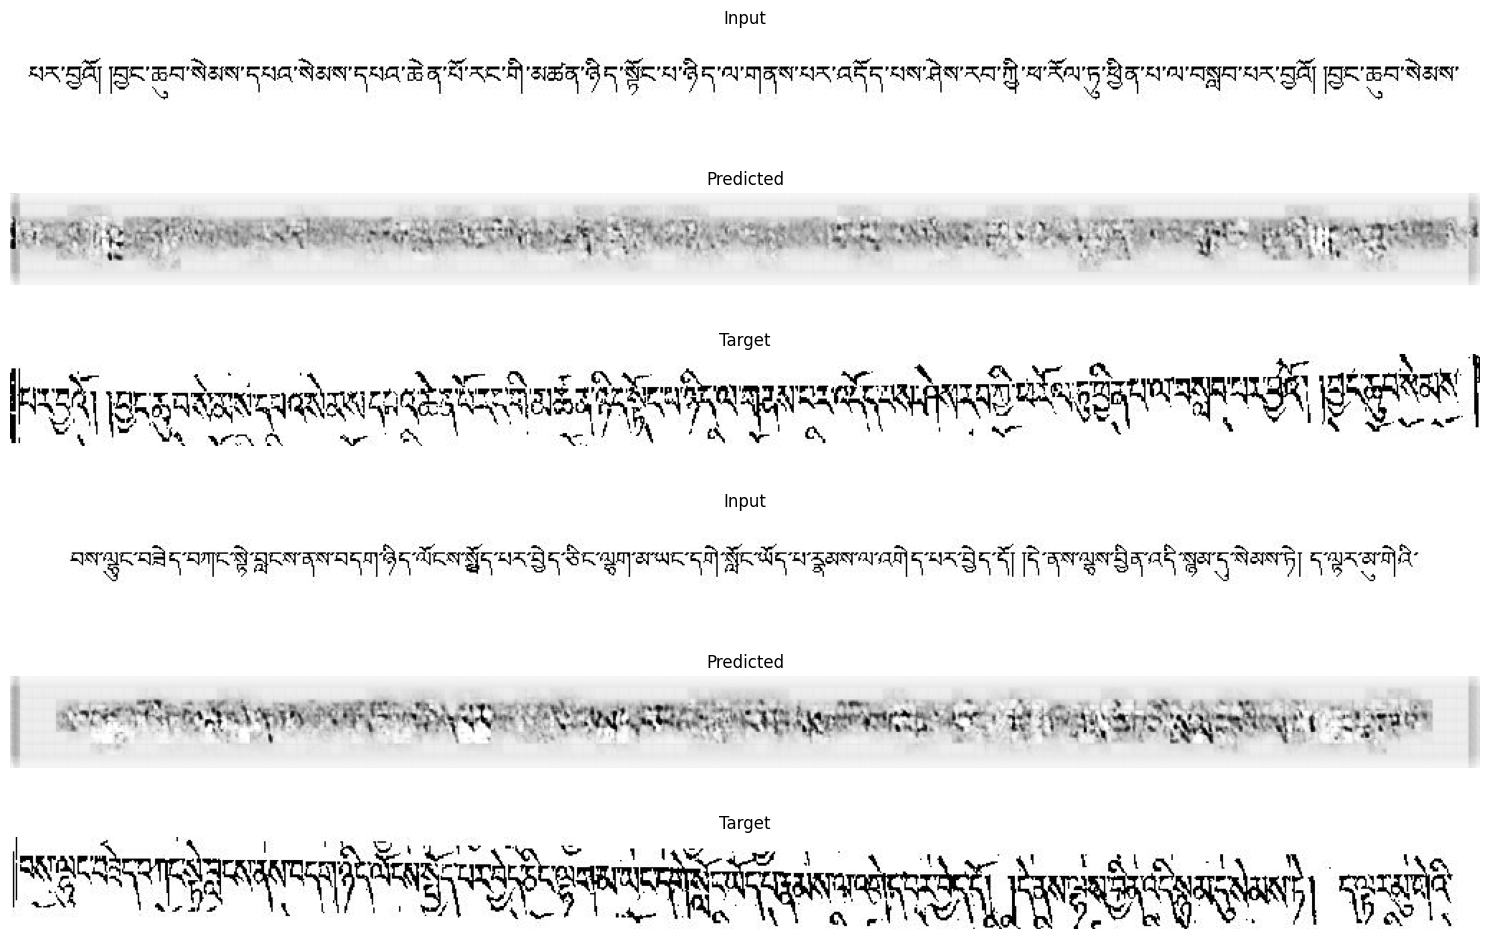

In [32]:
import matplotlib.pyplot as plt

def display_images(dataset, model, num_images=2):
    plt.figure(figsize=(15, 10))  # Adjust figure size for better vertical display
    for i, (x, y) in enumerate(dataset.take(num_images)):
        # Generate model predictions
        predicted_y = model.predict(x)

        # Display the input image
        plt.subplot(num_images*3, 1, i*3 + 1)
        plt.imshow(x[0, :, :, 0], cmap='gray')
        plt.title("Input")
        plt.axis('off')

        # Display the predicted image
        plt.subplot(num_images*3, 1, i*3 + 2)
        plt.imshow(predicted_y[0, :, :, 0], cmap='gray')
        plt.title("Predicted")
        plt.axis('off')

        # Display the target image
        plt.subplot(num_images*3, 1, i*3 + 3)
        plt.imshow(y[0, :, :, 0], cmap='gray')
        plt.title("Target")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming `dataset` is still available and contains your test set
display_images(dataset, model)
